In [1]:
import pickle
import numpy as np 
import pandas as pd
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import matplotlib as mpl
import os 
import glob

mpl.rcParams['figure.figsize'] = (5,5)
mpl.rcParams['figure.dpi'] = 150
mpl.rcParams["image.origin"] = 'lower'

In [68]:
model_dir = "../models/v6_detseparated/"
model_name = "v6_detseparated"
model_version = "v3"
os.makedirs(model_dir, exist_ok = True)

# Data preparation
## Input: 
- E seed
- eta,phi,z seed
- E cluster
- delta_eta,delta_phi,

Filter only windows with the calo

In [3]:
files_ele = "/storage/ECAL/training_data/electrons/training/"
files_gamma = "/storage/ECAL/training_data/gammas/numpy_v8/training/"

In [4]:
files_ele = "/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/electrons/numpy_v8/training/"
files_gamma = "/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/gammas/numpy_v8/training/"

In [4]:
datas_ele = []

for f in glob.glob(files_ele+"*.pkl"):
    d = pickle.load(open(f, "rb"))   
    datas_ele.append(d[d.is_seed == False])
    
data_ele = pd.concat(datas_ele, ignore_index=True)
data_ele["particle"] = "electron"
print("N events ele: ",len(data_ele))

datas_gamma = []
for f in glob.glob(files_gamma+"*.pkl"):
    d = pickle.load(open(f, "rb"))  
    datas_gamma.append(d[d.is_seed==False])
    
data_gamma = pd.concat(datas_gamma, ignore_index=True)
data_gamma["particle"] = "gamma"
print("N events gamma: ",len(data_gamma))

if data_ele.shape[0]> data_gamma.shape[0]:
    data = pd.concat([data_gamma, data_ele.iloc[0:len(data_gamma)]], ignore_index=True)
else:
    data = pd.concat([data_gamma.iloc[0:len(data_ele)], data_ele], ignore_index=True)
    
del data_gamma
del data_ele

N events ele:  23603630
N events gamma:  20426249


Balance gamma and electron

In [5]:
data_EB = data[abs(data.seed_eta)<1.479]
data_EE = data[abs(data.seed_eta)>=1.479]

In [6]:
print("Sample in EB:", len(data[abs(data.seed_eta) <1.479]))
print("Sample in EE:", len(data[abs(data.seed_eta) >=1.479]))
print("Sample in EB in SC:", len(data[(abs(data.seed_eta) <1.479)&(data.in_scluster)]))
print("Sample in EE in SC:", len(data[(abs(data.seed_eta) >=1.479)&(data.in_scluster)]))
print("N in supercluster: ", len(data[ data.in_scluster]))
print("N out supercluster: ", len(data[data.in_scluster == False]))
w = len(data[(data.is_seed == False) & (data.in_scluster == False)]) / len(data[(data.is_seed == False) & (data.in_scluster==True)])
print(w)

Sample in EB: 22710542
Sample in EE: 18141956
Sample in EB in SC: 736993
Sample in EE in SC: 349943
N in supercluster:  1086936
N out supercluster:  39765562
36.5850077649466


In [7]:
print("caloMatch samples: ", len(data[data.is_calo_matched]))
print("Not caloMatch samples: ", len(data[data.is_calo_matched ==False]))

caloMatch samples:  27531639
Not caloMatch samples:  13320859


## Check plots

In [9]:
data_in = data[ (data.is_seed == False) & data.in_scluster]
data_out =  data[(data.is_seed == False) & (data.in_scluster == False)]

## Weights by DeltaPhi

In [7]:
data.columns

Index(['cl_f5_r9', 'cl_f5_sigmaIetaIeta', 'cl_f5_sigmaIetaIphi',
       'cl_f5_sigmaIphiIphi', 'cl_nxtals', 'cl_swissCross', 'cluster_deta',
       'cluster_dphi', 'cluster_iz', 'en_cluster', 'en_seed', 'en_true',
       'et_cluster', 'et_seed', 'et_true', 'in_mustache', 'in_scluster',
       'index', 'is_calo_matched', 'is_seed', 'max_dr_cluster',
       'max_en_cluster', 'mustache_seed_index', 'nclusters', 'seed_eta',
       'seed_f5_r9', 'seed_f5_sigmaIetaIeta', 'seed_f5_sigmaIetaIphi',
       'seed_f5_sigmaIphiIphi', 'seed_iz', 'seed_nxtals', 'seed_phi',
       'seed_swissCross', 'window_index', 'particle'],
      dtype='object')

In [6]:
cols = ["seed_eta", "seed_phi", "seed_iz","en_seed","et_seed",
        "cluster_deta", "cluster_dphi", "en_cluster", "et_cluster",
       "seed_f5_r9", "seed_f5_sigmaIetaIeta","seed_f5_sigmaIetaIphi","seed_f5_sigmaIphiIphi","seed_swissCross","seed_nxtals",
        "cl_f5_r9", "cl_f5_sigmaIetaIeta","cl_f5_sigmaIetaIphi","cl_f5_sigmaIphiIphi","cl_swissCross", "cl_nxtals"]

In [44]:
data = data_EE

In [46]:
inSC = len(data[(data.is_seed == False) & (data.in_scluster == True)])
data = pd.concat([data[(data.is_seed == False) & (data.in_scluster == True)],
                  data[(data.is_seed == False) & (data.in_scluster == False)].iloc[:25*inSC]])

In [47]:
X = data[ cols ].values
truth = data[["in_scluster"]].values
y = np.array(truth[:], dtype=int)

In [48]:
w = len(data[(data.is_seed == False) & (data.in_scluster == False)]) / len(data[(data.is_seed == False) & (data.in_scluster==True)])
print(w)

25.0


In [49]:
data["w"] = data.in_scluster.apply(lambda a: w if a else 1.)
weight = data.w.values

In [35]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, QuantileTransformer
from sklearn.model_selection import train_test_split
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pickle.dump(scaler, open(model_dir + "/scaler_model_v3_EB.pkl", "wb"))

In [51]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, QuantileTransformer
from sklearn.model_selection import train_test_split
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pickle.dump(scaler, open(model_dir+"/scaler_model_{}_EE.pkl".format(model_version), "wb"))

In [68]:
scaler.mean_

array([-9.48937722e-02, -2.59092069e-02, -3.23802034e-02,  8.54387012e+01,
        1.95493967e+01, -7.99008024e-03,  1.68780274e-05,  8.92748605e+00,
        1.92283524e+00,  1.08804190e+00,  3.39450646e-02,  1.85485538e-05,
        4.13554904e-02,  4.96716655e-01,  5.44590774e+00,  4.09401210e+00,
        3.71462585e-02,  4.80538918e-05,  4.39461957e-02,  5.70297494e-01,
        3.15806715e+00])

In [69]:
scaler.scale_

array([2.27502784e+00, 1.80358311e+00, 9.99475624e-01, 1.25874656e+02,
       2.62122915e+01, 1.01794340e-01, 1.81101293e-01, 6.05398279e+00,
       1.77231292e+00, 5.03589571e-01, 1.40048073e-02, 4.14562658e-04,
       1.53689902e-02, 4.13270103e-01, 5.68762983e+00, 9.93354108e+00,
       1.65018741e-02, 5.45041026e-04, 1.80243836e-02, 4.37347302e-01,
       4.28826919e+00])

In [52]:
X_train, X_val, y_train, y_val, w_train, w_val = train_test_split(X_scaled, y, weight, test_size=0.40)

# Training

In [53]:
# Import all the required Libraries
import tensorflow
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.models import Model, Sequential
from keras.layers import Dense, Conv2D, Dropout, BatchNormalization, Input, Reshape, Flatten, Deconvolution2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, Lambda
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import adam
from keras import callbacks
from keras import backend as K
from keras import regularizers
from keras.callbacks import *

In [61]:
model = Sequential()
model.add(Dense(100, input_dim=X_val.shape[1], activation="relu",kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.05))
model.add(Dense(100, activation="relu",kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.05))
model.add(Dense(100, activation="relu"))
model.add(Dropout(0.05))
model.add(Dense(100, activation="relu"))
model.add(Dropout(0.05))
model.add(Dense(1, activation="sigmoid"))


model.compile(optimizer='adagrad',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_43 (Dense)             (None, 100)               2200      
_________________________________________________________________
dropout_35 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_44 (Dense)             (None, 100)               10100     
_________________________________________________________________
dropout_36 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_45 (Dense)             (None, 100)               10100     
_________________________________________________________________
dropout_37 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_46 (Dense)             (None, 100)              

In [67]:
model = Sequential()
model.add(Dense(200, input_dim=X_val.shape[1], activation="relu",kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.1))
model.add(Dense(200, activation="relu",kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.1))
model.add(Dense(100, activation="relu"))
model.add(Dropout(0.05))
model.add(Dense(100, activation="relu"))
model.add(Dropout(0.05))
model.add(Dense(50, activation="relu"))
model.add(Dropout(0.01))
model.add(Dense(1, activation="sigmoid"))


model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_48 (Dense)             (None, 200)               4400      
_________________________________________________________________
dropout_39 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_49 (Dense)             (None, 200)               40200     
_________________________________________________________________
dropout_40 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_50 (Dense)             (None, 100)               20100     
_________________________________________________________________
dropout_41 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_51 (Dense)             (None, 100)             

In [23]:
import math
def step_decay(epoch):
    initial_lrate = 0.4
    drop = 0.65
    epochs_drop = 5.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    if lrate < 0.002: return 0.002
    return lrate

In [39]:
auto_save = ModelCheckpoint(model_dir+ "/model_{}_EB.hd5".format(model_version), monitor='val_loss', 
                    verbose=1, save_best_only=True, save_weights_only=False, 
                    mode='auto', period=2)

early_stop = EarlyStopping(monitor='val_loss', min_delta=0.0001, 
                            patience=20, verbose=1)


#lr_scheduler = callbacks.LearningRateScheduler(step_decay, verbose=1)

history = model.fit(
            X_train, y_train,
            sample_weight = w_train,
            batch_size = 4096,
            epochs=400,
            shuffle=True,
            validation_data = (X_val, y_val, w_val),
            callbacks = [early_stop, auto_save] #lr_scheduler
            )

Train on 13626325 samples, validate on 9084217 samples
Epoch 1/400
13626325/13626325 [==============================] - 65s 5us/step - loss: 0.3130 - accuracy: 0.9435 - val_loss: 0.2333 - val_accuracy: 0.9480
Epoch 2/400
13626325/13626325 [==============================] - 64s 5us/step - loss: 0.2306 - accuracy: 0.9508 - val_loss: 0.2152 - val_accuracy: 0.9493

Epoch 00002: val_loss improved from inf to 0.21516, saving model to ../models/v6_detseparated//model_v3_EB.hd5
Epoch 3/400
13626325/13626325 [==============================] - 65s 5us/step - loss: 0.2196 - accuracy: 0.9523 - val_loss: 0.2081 - val_accuracy: 0.9554
Epoch 4/400
13626325/13626325 [==============================] - 64s 5us/step - loss: 0.2144 - accuracy: 0.9529 - val_loss: 0.2064 - val_accuracy: 0.9502

Epoch 00004: val_loss improved from 0.21516 to 0.20640, saving model to ../models/v6_detseparated//model_v3_EB.hd5
Epoch 5/400
13626325/13626325 [==============================] - 64s 5us/step - loss: 0.2110 - accura

13626325/13626325 [==============================] - 64s 5us/step - loss: 0.1862 - accuracy: 0.9574 - val_loss: 0.1826 - val_accuracy: 0.9542
Epoch 84/400
13626325/13626325 [==============================] - 64s 5us/step - loss: 0.1857 - accuracy: 0.9575 - val_loss: 0.1814 - val_accuracy: 0.9607

Epoch 00084: val_loss improved from 0.18190 to 0.18143, saving model to ../models/v6_detseparated//model_v3_EB.hd5
Epoch 85/400
13626325/13626325 [==============================] - 64s 5us/step - loss: 0.1859 - accuracy: 0.9575 - val_loss: 0.1815 - val_accuracy: 0.9624
Epoch 86/400
13626325/13626325 [==============================] - 64s 5us/step - loss: 0.1859 - accuracy: 0.9574 - val_loss: 0.1815 - val_accuracy: 0.9585

Epoch 00086: val_loss did not improve from 0.18143
Epoch 87/400
13626325/13626325 [==============================] - 64s 5us/step - loss: 0.1861 - accuracy: 0.9574 - val_loss: 0.1822 - val_accuracy: 0.9540
Epoch 88/400
13626325/13626325 [==============================] - 64s 

In [ ]:
auto_save = ModelCheckpoint(model_dir+ "/model_{}_EE.hd5".format(model_version) , monitor='val_loss', 
                    verbose=1, save_best_only=True, save_weights_only=False, 
                    mode='auto', period=3)

early_stop = EarlyStopping(monitor='val_loss', min_delta=0.0001, 
                            patience=15, verbose=1)


#lr_scheduler = callbacks.LearningRateScheduler(step_decay, verbose=1)

history = model.fit(
            X_train, y_train,
            sample_weight = w_train,
            batch_size = 4096,
            epochs=400,
            shuffle=True,
            validation_data = (X_val, y_val, w_val),
            callbacks = [early_stop, auto_save, ] #lr_scheduler
            )

Train on 5459110 samples, validate on 3639408 samples
Epoch 1/400
5459110/5459110 [==============================] - 31s 6us/step - loss: 0.4526 - accuracy: 0.9372 - val_loss: 0.2744 - val_accuracy: 0.9484
Epoch 2/400
5459110/5459110 [==============================] - 30s 6us/step - loss: 0.2784 - accuracy: 0.9485 - val_loss: 0.2663 - val_accuracy: 0.9631
Epoch 3/400
5459110/5459110 [==============================] - 31s 6us/step - loss: 0.2714 - accuracy: 0.9495 - val_loss: 0.2616 - val_accuracy: 0.9440

Epoch 00003: val_loss improved from inf to 0.26157, saving model to ../models/v6_detseparated//model_v3_EE.hd5
Epoch 4/400
5459110/5459110 [==============================] - 30s 6us/step - loss: 0.2681 - accuracy: 0.9503 - val_loss: 0.2512 - val_accuracy: 0.9575
Epoch 5/400
5459110/5459110 [==============================] - 31s 6us/step - loss: 0.2672 - accuracy: 0.9504 - val_loss: 0.2564 - val_accuracy: 0.9413
Epoch 6/400
5459110/5459110 [==============================] - 31s 6us/ste

>>> Computing AUC...
AUC score: 0.99343467334777
>>> Saving ROC curve...


/usr/local/lib/python3.6/dist-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


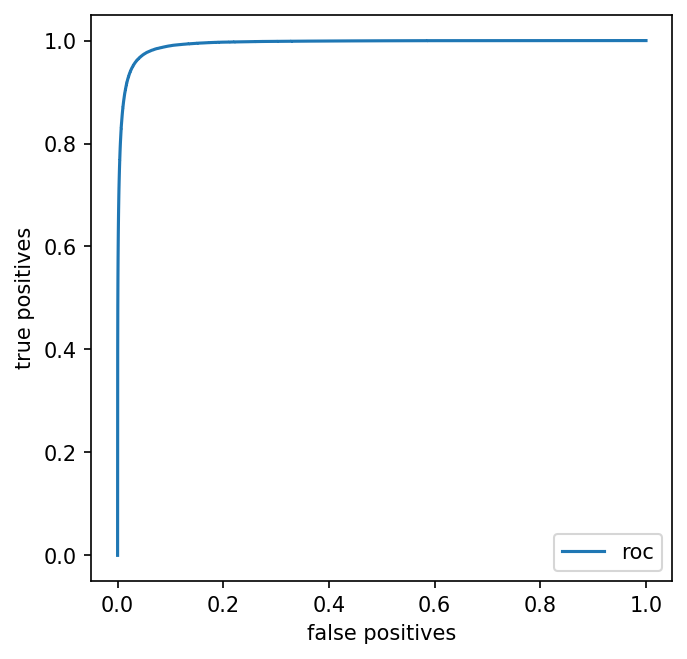

In [64]:
# Evalutation
print(">>> Computing AUC...")

from sklearn.metrics import roc_auc_score, roc_curve

pred = model.predict(X_val,batch_size=2048)
auc = roc_auc_score(y_val, pred, sample_weight=w_val)
print("AUC score: " + str(auc))

print(">>> Saving ROC curve...")
fp , tp, th = roc_curve(y_val, pred, sample_weight=w_val,drop_intermediate=True)
plt.plot(fp, tp, label="roc")
#plt.plot(fp, th, label="threshold")
plt.xlabel("false positives")
plt.ylabel("true positives")
plt.ylim(-0.05,1.05)

plt.legend()

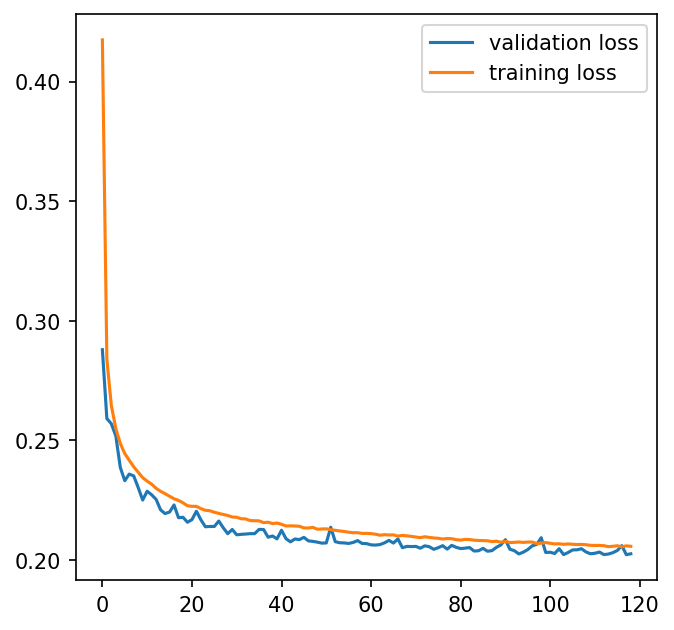

In [65]:
plt.plot(history.epoch, history.history["val_loss"], label="validation loss")
plt.plot(history.epoch, history.history["loss"], label="training loss")
plt.legend()

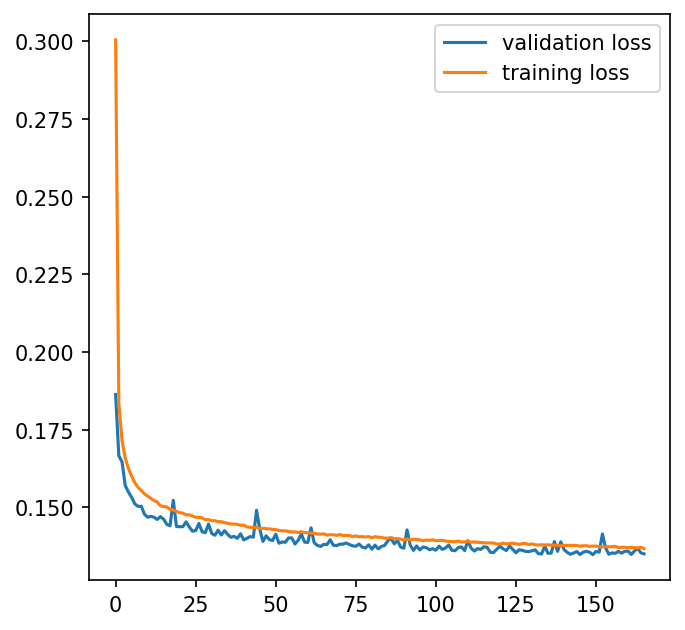

In [64]:
plt.plot(history.epoch, history.history["val_loss"], label="validation loss")
plt.plot(history.epoch, history.history["loss"], label="training loss")
plt.legend()

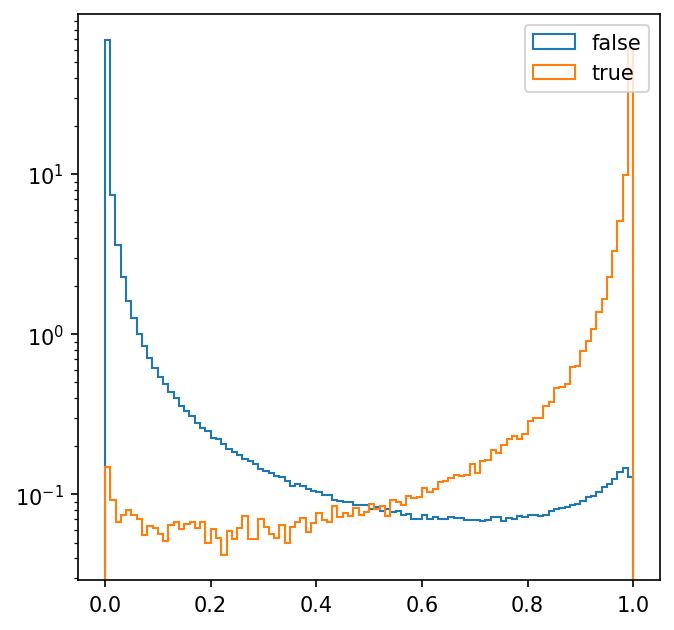

In [66]:
results = model.predict(X_val)
plt.hist(results[y_val==0], bins=100,density=True, label="false", histtype="step")
plt.hist(results[y_val==1], bins=100, density=True, label="true", histtype="step")
plt.yscale("log")
plt.legend()

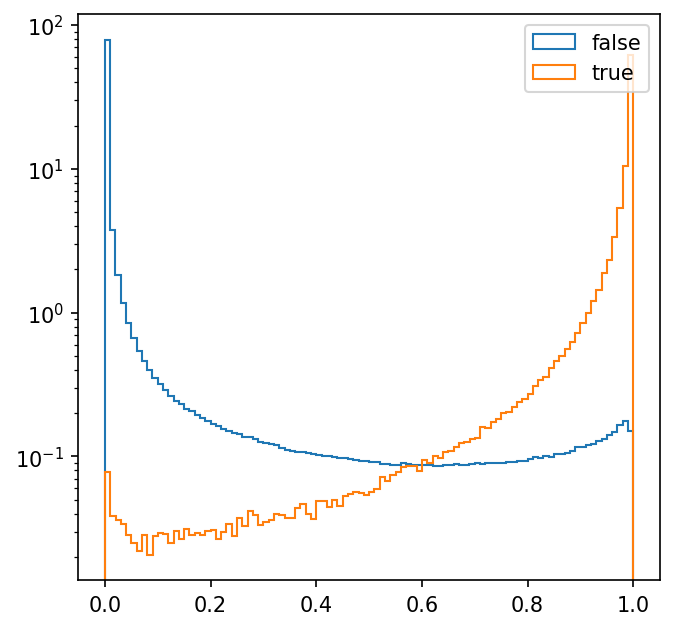

In [42]:
results = model.predict(X_val)
plt.hist(results[y_val==0], bins=100,density=True, label="false", histtype="step")
plt.hist(results[y_val==1], bins=100, density=True, label="true", histtype="step")
plt.yscale("log")
plt.legend()

In [43]:
plt.savefig(model_dir +"/output_model_v3_EB.png")

<Figure size 750x750 with 0 Axes>

# Some plots

In [1]:
from keras.models import load_model
model = load_model("models/model11_balanced_100_80_50.hd5")
scaler = pickle.load(open("models/scaler_gamma_electrons.pkl", "rb"))

Using TensorFlow backend.


OSError: Unable to open file (unable to open file: name = 'models/model11_balanced_100_80_50.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [27]:
fp , tp, th = roc_curve(y_test, pred)
fig, ax1 = plt.subplots(figsize=(7,6), dpi=100)
ax1.plot(fp, tp, label="roc", color="blue")

ax1.set_xlabel("Bkg contamination", fontsize=18)
ax1.set_ylabel("Signal efficiency", fontsize=18, color="blue")
ax1.set_ylim(0.850, 1.01)
ax1.set_xlim(0, 0.06)
#ax1.plot([0,1],[1,1],"b--")
ax1.tick_params("y",labelsize="large", labelcolor="blue")

ax2 = ax1.twinx()
ax2.plot(fp, th, label="threshold", color="red")
ax2.tick_params(axis='y', labelcolor="red", labelsize="large")
ax2.set_ylabel("Threshold", fontsize=18, color="red")
ax2.set_ylim(0, 1)
ax1.grid()
#ax2.grid(linestyle="dashed", color="red")

ax2.plot([0.01, 0.01], [0, 2], "g--")
ax2.set_yticks(np.arange(0, 1.1, 0.1))
#ax2.minorticks_on()

ax1.set_title("ROC curve", fontsize=20)
ax2.text(x = 0.048, y = 1.01, s="AUC=0.997", fontsize="large")

fig.tight_layout()

NameError: name 'y_test' is not defined

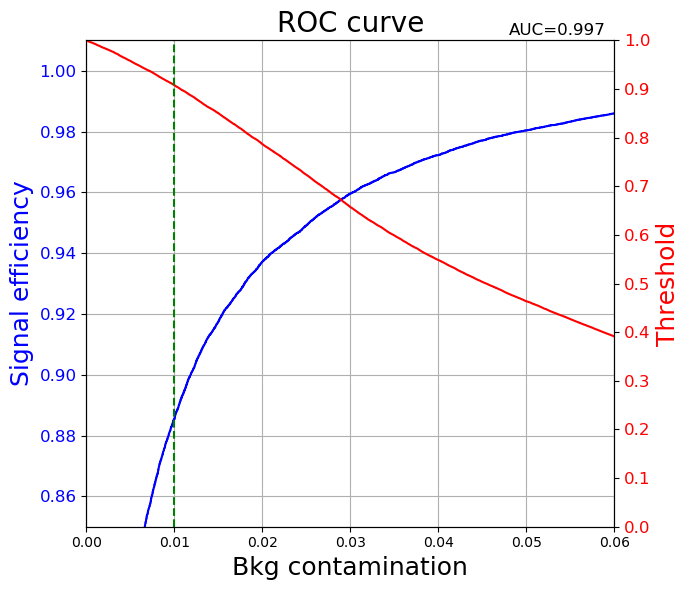

In [36]:
fp , tp, th = roc_curve(y_test, pred)
fig, ax1 = plt.subplots(figsize=(7,6), dpi=100)
ax1.plot(fp, tp, label="roc", color="blue")

ax1.set_xlabel("Bkg contamination", fontsize=18)
ax1.set_ylabel("Signal efficiency", fontsize=18, color="blue")
ax1.set_ylim(0.850, 1.01)
ax1.set_xlim(0, 0.06)
#ax1.plot([0,1],[1,1],"b--")
ax1.tick_params("y",labelsize="large", labelcolor="blue")

ax2 = ax1.twinx()
ax2.plot(fp, th, label="threshold", color="red")
ax2.tick_params(axis='y', labelcolor="red", labelsize="large")
ax2.set_ylabel("Threshold", fontsize=18, color="red")
ax2.set_ylim(0, 1)
ax1.grid()
#ax2.grid(linestyle="dashed", color="red")

ax2.plot([0.01, 0.01], [0, 2], "g--")
ax2.set_yticks(np.arange(0, 1.1, 0.1))
#ax2.minorticks_on()

ax1.set_title("ROC curve", fontsize=20)
ax2.text(x = 0.048, y = 1.01, s="AUC=0.997", fontsize="large")

fig.tight_layout()